#### 💡 Residual block 구축하기

- ResNet은 ResidualBlock 하나를 거칠 때마다 이미지 사이즈가 줄어들고, 채널 수는 늘어나는 구조
- 따라서 처음 들어오는 x값과 블록을 거친 출력값 out의 크기가 같아야만 한다. 
- 따라서 차이가 나는 경우 출력값의 크기와 입력값의 크기를 동일하게 하기 위해 별도의 컨볼루션 연산을 수행하여 입력 크기를 출력 크기와 맞춰준다.

In [10]:
import torch
from torch import nn

In [11]:
class ResidualBlock(nn.Module) :
    
    def __init__(self, in_channels, out_channels, stride=1) :
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # 컨볼루션 연산 2개를 포함한 블록 만들기
            # Batch Normalization : 각 배치의 평균과 분산을 이용해서 데이터를 정규화하는 방법으로 학습을 빠르게 할 수 있다.
        self.conv_block = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                                        nn.BatchNorm2d(self.out_channels),
                                        nn.ReLU(),
                                        nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                        nn.BatchNorm2d(self.out_channels))
        
        # 위의 설명 참고 (사이즈가 달라지거나, 채널이 달라지면 ~ 조건문 실행)
        if self.stride != 1 or self.in_channels != self.out_channels :
            self.downsample = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                                            nn.BatchNorm2d(self.out_channels))
            
    def forward(self, x) :
        out = self.conv_block(x)
        
        # 사이즈 조정이 필요하다면 입력값의 크기를 조정한다. 
        if self.stride != 1 or self.in_channels != self.out_channels :
            x = self.downsample(x)
            
        # Skip connection
        out = F.relu(x + out)
        return out

---------------------------------------------------------------------------------------------------------

#### 💡 ResNet 모델 구축하기

In [12]:
class ResNet(nn.Module) :
    def __init__(self, num_blocks, num_classes=10) :
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # 입력 이미지가 들어와 연산을 수행하는 기본층
        self.base = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())
        
        # 기본층을 제외한 4개의 블록이 필요하므로, self._make_layer를 이용하여 4개의 블록 묶음을 선언한다. 
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        
        # 합성곱 층들을 지나면 최종적으로 크기가 4x4인 feature map 512개가 나온다. 
        # 크기가 4x4인 평균 풀링을 이용하면 각 피쳐맵 당 1개의 평균값이 나오기 때문에 성분이 512개인 벡터를 얻을 수 있다.
        self.gap = nn.AvgPool2d(4) # 4 is filter size
        
        # 클래스가 10개인 이미지를 분류하는 것이므로 최종적으로 512개의 노드에서 10개의 노드로 가는 FC를 정의한다. 
        self.fc = nn.Linear(512, num_classes)
        
        
    def _make_layer(self, out_channels, num_blocks, stride) :
        # 블록의 반복 횟수만큼 stride를 저장
        strides = [stride] + [1]*(num_blocks-1)
        
        # ResidualBlock을 불러와서 append를 이용해 차례로 붙여준다.
        # 이때 이전 출력 채널 크기와 다음 입력 채널 크기가 같아야 한다. 
        layers = []
        for stride in strides :
            block = ResidualBlock(self.in_channels, out_channels, stride)
            layers.append(block) 
            self.in_channels = out_channels
            
        # nn.Sequential에 넣어 모델을 구축한다.
        # *리스트 : 리스트의 길이에 상관 없이 모든 성분을 별도로 nn.Sequential에 전달하는 역할을 한다. 
        return nn.Sequential(*layers)
        
    
    # ResNet 클래스 안에 연산을 행하는 forward
    def forward(self, x) :
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [13]:
# 클래스를 불러오는 함수
# 각 모델마다 블록의 반복 횟수를 리스트로 정의하여 입력한다. 
# 이를 통해 18, 34 외에 4개의 블록을 가진 레이어의 개수를 조정할 수 있다. 
def modeltype(model) :
    if model == 'resnet18' :
        return ResNet([2, 2, 2, 2])
    elif model == 'resnet34' :
        return ResNet([3, 4, 6, 3])

---------------------------------------------------------------------------------------------------------

#### 💡 ResNet18 학습 및 평가하기

- AlexNet 평가에서 사용한 코드로 학습과 평가 과정 동일하게 진행

---------------------------------------------------------------------------------------------------------

#### 📚 전체적으로 구성

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
import torchsummary

In [4]:
# CIFAR10 데이터 세트 불러오기
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [8]:
# GPU 연산 체크
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available')

cuda:0 is available


In [16]:
# 모델 선언
model = modeltype('resnet18').to(device)
print(model)

ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne

In [17]:
# 모델 출력
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
     ResidualBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [19]:
# 손실 함수 및 최적화 방법 정의하기
criterion = nn.CrossEntropyLoss()
resnet = modeltype('resnet18').to(device)
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [20]:
# 모델 학습하기

# 그래프를 그리기 위한 loss 저장용 리스트
loss_ = []

# 배치개수
n = len(trainloader)

for epoch in range(50) :
    running_loss = 0.0
    for data in trainloader :
        # 원래는 inputs, labels = data로 하는데 각각 device 붙여주기 위해 인덱스로 따로 뗌
        # 배치 데이터
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        
        # 예측값 산출
        outputs = resnet(inputs)
        
        # 손실함수 계산
        loss = criterion(outputs, labels)
        
        # 손실 함수 기준으로 역전파 선언
        loss.backward()
        
        # 가중치 최적화
        optimizer.step()
        
        running_loss += loss.item()
        
    loss_.append(running_loss/n)
    print('[%d] loss: %.3f' % (epoch+1, running_loss/len(trainloader)))

[1] loss: 1.330
[2] loss: 0.831
[3] loss: 0.619
[4] loss: 0.481
[5] loss: 0.377
[6] loss: 0.277
[7] loss: 0.195
[8] loss: 0.140
[9] loss: 0.103
[10] loss: 0.086
[11] loss: 0.068
[12] loss: 0.066
[13] loss: 0.053
[14] loss: 0.049
[15] loss: 0.041
[16] loss: 0.043
[17] loss: 0.036
[18] loss: 0.036
[19] loss: 0.034
[20] loss: 0.031
[21] loss: 0.029
[22] loss: 0.027
[23] loss: 0.028
[24] loss: 0.025
[25] loss: 0.022
[26] loss: 0.022
[27] loss: 0.021
[28] loss: 0.021
[29] loss: 0.021
[30] loss: 0.019
[31] loss: 0.019
[32] loss: 0.018
[33] loss: 0.016
[34] loss: 0.016
[35] loss: 0.018
[36] loss: 0.016
[37] loss: 0.014
[38] loss: 0.016
[39] loss: 0.014
[40] loss: 0.015
[41] loss: 0.010
[42] loss: 0.013
[43] loss: 0.013
[44] loss: 0.012
[45] loss: 0.010
[46] loss: 0.015
[47] loss: 0.010
[48] loss: 0.011
[49] loss: 0.010
[50] loss: 0.013


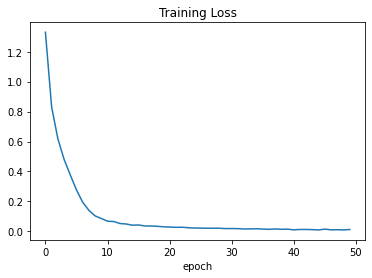

In [21]:
# 학습 손실 함수 그래프 그리기
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [24]:
# 모델 저장 경로와 모델평.pth 입력 (폴더는 만들어주어야 함)
PATH = './model/cifal_resnet.pth'
# 모델 저장
torch.save(resnet.state_dict(), PATH)

In [25]:
# 평가하기

# 정답 개수
correct = 0

# 전체 개수
total = 0

# 평가 시에는 requires_grad 비활성화
with torch.no_grad() :
    # 평가 시에는 드롭아웃 등과 같은 정규화 작업 X (비활성화)
    resnet.eval()
    for data in testloader :
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Test accuracy: %.2f %%' %(100*correct/total))

Test accuracy: 84.77 %


✨ 평가 결과, AlexNet 보다 정확도가 높게 나왔다 !!!